## Task a)

- As behavioural policy, the simple policy from exercise 3.2 is used.
- The evaluation of the policy happens as in the on-policy MC approach in exercise 3.2, with 2 notable differences:
	1. The algorithm is now off-policy (it does not use the action-value function to choose the next action at all)
	2. The reward is scaled by the ratio of the target policy to the behavioural policy (importance sampling)

Disclaimer:
I decided to implement importance sampling on the frozen lake environment rather than the grid-world environment due to its non-deterministic properties. I hope that the results from this exercise are still valuable.

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [10]:
class MCOffPolicy:
	def __init__(self, gamma=1, epsilon=0.1):
		self.moves = [0, 1, 2, 3]
		self.probabilities = [0.15, 0.35, 0.35, 0.15]
		self.returns = [[[] for _ in range(4)] for _ in range(16)]
		self.v = np.random.rand(16, 4)
		self.gamma = gamma
		self.epsilon = epsilon


	def behaviour_policy(self, observation):
		return np.random.choice(self.moves, p=self.probabilities)

	def target_policy(self, observation):
		return np.random.choice(np.asarray(self.v[observation] == np.max(self.v[observation])).nonzero()[0])

	def evaluate(self, path, actions, rewards):
		g = 0
		p = 1
		for t in reversed(range(len(path) - 1)):
			# calculate ratio of target policy to behaviour policy with every step
			# (generating the relative probability of the trajectory while traversing that same trajectory)
			if sum(self.v[path[t]]) != 0:
				p = p * ((self.v[path[t]][actions[t]] / sum(self.v[path[t]])) / self.probabilities[actions[t]])
			else:
				p = p * (0.25 / self.probabilities[actions[t]])
			g = self.gamma * g + rewards[t]
			if (path[t], actions[t]) not in zip(path[:t], actions[:t]):
				self.returns[path[t]][actions[t]].append(g*p)  #scale reward g by ratio p
				#self.returns[path[t]][actions[t]].append(g)
				self.v[path[t]][actions[t]] = np.average(self.returns[path[t]][actions[t]])

		return self.v

	def get_v(self):
		return self.v

In [11]:
def run_episode(env, policy):
    observation, info = env.reset()  #obligatory reset

    path = [observation]
    rewards = []
    actions = []

    episode_over = False
    while not episode_over:
        action = policy.behaviour_policy(observation)
        actions.append(action)

        observation, reward, terminated, truncated, info = env.step(action)  #action is performed

        path.append(observation)
        rewards.append(reward)

        #if either a termination condition is met or the maximum episode length is reached,
        #the loop needs to end
        episode_over = terminated or truncated

    return path, actions, rewards


In [12]:
def run(policy, n=100):
    env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)

    rewards_list = []
    for _ in range(n):
        path, actions, rewards = run_episode(env, policy)
        policy.evaluate(path, actions, rewards)
        rewards_list.append(rewards[-1])

    return policy.get_v(), rewards_list

In [13]:
policy = MCOffPolicy(gamma=1)
value_func, rewards_list = run(policy, n=10000)
print(value_func)
print(sum(rewards_list))

[[0.00000000e+00 0.00000000e+00 1.31523287e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.52018827e-03]
 [0.00000000e+00 0.00000000e+00 1.57007476e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.45830918e-01 5.62125150e-01 2.74928314e-01 2.60123451e-01]
 [0.00000000e+00 3.78821269e-03 0.00000000e+00 0.00000000e+00]
 [2.87661216e-02 9.04802066e-01 4.90900193e-01 6.05167634e-01]
 [0.00000000e+00 0.00000000e+00 3.54911201e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.24602608e-03 0.00000000e+00]
 [2.99331149e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.85663771e-01 1.77411239e-01 9.58900044e-02 3.36322482e-01]
 [2.83130532e-02 6.03529674e-01 7.92159128e-01 9.31001357e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.27553875e+00]
 [0.00000000e+00 4.45824436e-02 1.93205693e-02 2.26519788e+00]
 [5.67549965e-01 9.75866441e-01 7.84049972e-01 4.928211

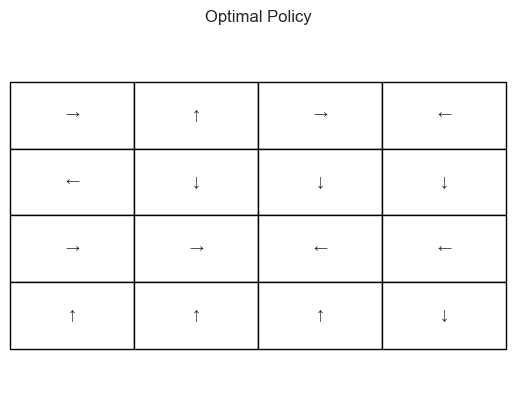

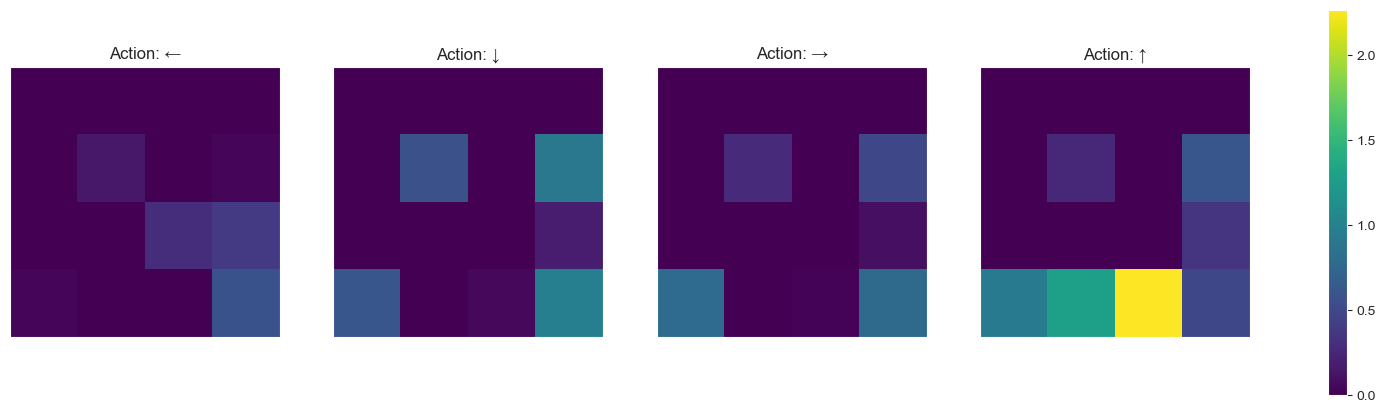

In [14]:
optimal_policy = np.asarray(list(map(np.argmax, value_func))).reshape(4, 4)
actions_labels = ['←', '↓', '→', '↑']
policy_grid = np.array([[actions_labels[action] for action in row] for row in optimal_policy])

fig, ax = plt.subplots()
ax.set_title('Optimal Policy')
ax.axis('off')
table = ax.table(cellText=policy_grid, loc='center', cellLoc='center')
table.scale(1, 4)
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for a in range(4):
    ax = axes[a]
    q_values = value_func[:, a].reshape(4, 4)
    im = ax.imshow(q_values, vmin=np.min(value_func), vmax=np.max(value_func), cmap='viridis')
    ax.set_title("Action: %s" % actions_labels[a])
    ax.set_xticks([]) # remove x-axis ticks
    ax.set_yticks([]) # remove y-axis ticks
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

In [15]:
def run_episode_target(env, policy):
    observation, info = env.reset()  #obligatory reset

    path = [observation]
    rewards = []
    actions = []

    episode_over = False
    while not episode_over:
        action = policy.target_policy(observation)
        actions.append(action)

        observation, reward, terminated, truncated, info = env.step(action)  #action is performed

        path.append(observation)
        rewards.append(reward)

        #if either a termination condition is met or the maximum episode length is reached,
        #the loop needs to end
        episode_over = terminated or truncated

    return path, actions, rewards

In [16]:
def run_target(policy, n=100):
    env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)

    rewards_list = []
    for _ in range(n):
        path, actions, rewards = run_episode_target(env, policy)
        rewards_list.append(rewards[-1])

    return policy.get_v(), rewards_list

In [9]:
#evaluationg when not using importance sampling
value_func, rewards_list = run_target(policy, n=1000)
print(value_func)
total_reward_no_importance_sampling = sum(rewards_list)
print(total_reward_no_importance_sampling)

[[0.02588235 0.02396804 0.0225366  0.02593466]
 [0.01748252 0.02281491 0.02089757 0.02906977]
 [0.03633491 0.03095559 0.03785011 0.03012048]
 [0.02337662 0.01515152 0.00909091 0.02486188]
 [0.04160689 0.02747626 0.02592    0.02222222]
 [0.19703793 0.77547328 0.35138506 0.62141583]
 [0.09387755 0.05564648 0.09734513 0.00787402]
 [0.95412975 0.2516234  0.11850342 0.14017565]
 [0.03666667 0.0626506  0.04732824 0.07637655]
 [0.10699588 0.17283951 0.15028902 0.09090909]
 [0.30882353 0.26548673 0.19354839 0.08474576]
 [0.07236748 0.66663746 0.44171728 0.14242001]
 [0.6598999  0.52730523 0.21306893 0.81238137]
 [0.1221374  0.24347826 0.27467811 0.25757576]
 [0.35294118 0.60619469 0.6036036  0.48695652]
 [0.98865801 0.08875192 0.87894777 0.15410058]]
301.0


In [17]:
#evaluating when using importance sampling
value_func, rewards_list = run_target(policy, n=1000)
print(value_func)
total_reward_importance_sampling = sum(rewards_list)
print(total_reward_importance_sampling)

[[0.00000000e+00 0.00000000e+00 1.31523287e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.52018827e-03]
 [0.00000000e+00 0.00000000e+00 1.57007476e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.45830918e-01 5.62125150e-01 2.74928314e-01 2.60123451e-01]
 [0.00000000e+00 3.78821269e-03 0.00000000e+00 0.00000000e+00]
 [2.87661216e-02 9.04802066e-01 4.90900193e-01 6.05167634e-01]
 [0.00000000e+00 0.00000000e+00 3.54911201e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.24602608e-03 0.00000000e+00]
 [2.99331149e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.85663771e-01 1.77411239e-01 9.58900044e-02 3.36322482e-01]
 [2.83130532e-02 6.03529674e-01 7.92159128e-01 9.31001357e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.27553875e+00]
 [0.00000000e+00 4.45824436e-02 1.93205693e-02 2.26519788e+00]
 [5.67549965e-01 9.75866441e-01 7.84049972e-01 4.928211

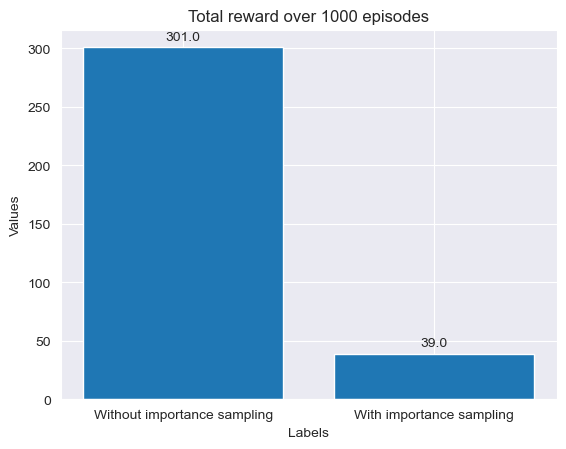

In [18]:
values = [total_reward_no_importance_sampling, total_reward_importance_sampling]
labels = ['Without importance sampling', 'With importance sampling']

fig, ax = plt.subplots()
ax.bar(labels, values)

# Add some text for labels, title, etc.
ax.set_xlabel('Labels')
ax.set_ylabel('Values')
ax.set_title('Total reward over 1000 episodes')

# Function to add labels on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(ax.patches)

plt.show()

#### Reflection:
- The use of importance sampling can improve a given problem, but as it drastically increases variance, the sample size needs to increase in the same drastic manner to combat this effect.
- Due to this increased variance, both the convergence speed and the accuracy can be affected negatively, however, in some environments the final accuracy after convergence should be better than without importance sampling.
- In an environment such as the one presented here (with non-deterministic action effects), I believe that the increased variance when using importance sampling combined with the variance caused by the non-deterministic environment leads to worse results when using importance sampling than without, especially with lower sample sizes.
- In fact, in this case, just using off-policy MC led to the agent reaching the goal roughly 30% of the time, while when including importance sampling, it only reaches the goal 4-5% of the time.